In [2]:
import sys
import os
import json
import torch
import pickle
import random

# from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

import numpy as np
from collections import Counter
from models.CNN_BiLSTM import CNN_BiLSTM
from utils import sent2wordemb, label_encode
import torch.nn as nn

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_encoded(directory, filename):
    filepath = os.path.join(directory, filename)
    
    with open(filepath, 'rb') as f:
        target_encoded = pickle.load(f)
    
    return target_encoded
def save_encoded(target_encoded, directory, filename):
    if not os.path.exists(os.path.join(directory)):
        os.makedirs(os.path.join(directory))
         
    filepath = os.path.join(directory, filename)
    # print(filepath)

    with open(filepath, 'wb') as f:
        pickle.dump(target_encoded, f)

# Data

In [4]:
with open("../data/train.json") as json_file:
    data = json.load(json_file)

In [5]:
print(f"Number of documents : {len(data)}")

Number of documents : 247


#### Looping through each document

In [6]:
total_sentences = 0
group = []
for index,doc in enumerate(data):
    print(f"Document number : {index}")
    print(f"Number of sentences : {len(doc['annotations'][0]['result'])}")
    total_sentences += len(doc['annotations'][0]['result'])
    group.append(doc['meta']['group'])
    
print(f"Avg sentences = {total_sentences/len(data):.2f}")

Document number : 0
Number of sentences : 91
Document number : 1
Number of sentences : 72
Document number : 2
Number of sentences : 200
Document number : 3
Number of sentences : 119
Document number : 4
Number of sentences : 184
Document number : 5
Number of sentences : 211
Document number : 6
Number of sentences : 140
Document number : 7
Number of sentences : 87
Document number : 8
Number of sentences : 228
Document number : 9
Number of sentences : 99
Document number : 10
Number of sentences : 62
Document number : 11
Number of sentences : 213
Document number : 12
Number of sentences : 111
Document number : 13
Number of sentences : 199
Document number : 14
Number of sentences : 188
Document number : 15
Number of sentences : 271
Document number : 16
Number of sentences : 43
Document number : 17
Number of sentences : 82
Document number : 18
Number of sentences : 171
Document number : 19
Number of sentences : 149
Document number : 20
Number of sentences : 95
Document number : 21
Number of 

In [7]:
print(f"Number of law groups : \n{set(group)}")

Number of law groups : 
{'Tax', 'Criminal'}


#### Looping through each document + sentence

In [8]:
labels = []
for index,doc in enumerate(data):
    char_count = 0
    group = doc['meta']['group']
    print(f"Document number : {index:<6} Law Type : {group}")
    # print(f"Number of sentences : {len(doc['annotations'][0]['result'])}")
    if doc['annotations'][0]['result'] != []:
        for sentence_data in doc['annotations'][0]['result']:
            char_count += len(sentence_data['value']['text'])
            labels.append(sentence_data['value']['labels'][0])
        print(f"Avg number of chars : {char_count/len(doc['annotations'][0]['result']):.2f}")
    else:
        print(f"{'Document is empty':-^60}")

Document number : 0      Law Type : Criminal
Avg number of chars : 180.81
Document number : 1      Law Type : Tax
Avg number of chars : 153.39
Document number : 2      Law Type : Criminal
Avg number of chars : 193.93
Document number : 3      Law Type : Tax
Avg number of chars : 222.87
Document number : 4      Law Type : Tax
Avg number of chars : 183.04
Document number : 5      Law Type : Criminal
Avg number of chars : 143.89
Document number : 6      Law Type : Tax
Avg number of chars : 202.29
Document number : 7      Law Type : Criminal
Avg number of chars : 118.03
Document number : 8      Law Type : Criminal
Avg number of chars : 140.69
Document number : 9      Law Type : Criminal
Avg number of chars : 181.81
Document number : 10     Law Type : Criminal
Avg number of chars : 153.18
Document number : 11     Law Type : Tax
Avg number of chars : 177.47
Document number : 12     Law Type : Tax
Avg number of chars : 156.68
Document number : 13     Law Type : Criminal
Avg number of chars : 1

In [9]:
print(set(labels))

{'ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO'}


In [10]:
Counter(labels)

Counter({'PREAMBLE': 4167,
         'NONE': 1423,
         'FAC': 5744,
         'ARG_RESPONDENT': 698,
         'RLC': 752,
         'ARG_PETITIONER': 1315,
         'ANALYSIS': 10695,
         'PRE_RELIED': 1431,
         'RATIO': 674,
         'RPC': 1081,
         'ISSUE': 367,
         'STA': 481,
         'PRE_NOT_RELIED': 158})

# Training through 1 document

## Label Encoding

In [11]:
label_encoder = label_encode(list(set(labels)))
# del labels

In [12]:
label_encoder.transform(["ISSUE"])

array([4])

In [13]:
label_encoder.inverse_transform([2])

array(['ARG_RESPONDENT'], dtype='<U14')

In [14]:
train_document = data[0]['annotations'][0]['result']
len(train_document)

91

In [15]:
def train(model : object, loss_fn : object,
          inp : torch.TensorType, target : torch.TensorType) -> float:
    """
    Train the decoder model for a single step using the given input and target sequences.

    Args:
        decoder (object): The decoder model to be trained.
        decoder_optimizer (object): The optimizer for updating the decoder's parameters.
        inp (torch.TensorType): The input sequence tensor.
        target (torch.TensorType): The target sequence tensor.

    Returns:
        float: The normalized loss for the current training step, averaged over the sequence length.
    """
    output = model(inp).unsqueeze(0)
    # print(f"output size: {output.size()}, target_size: {target.size()} ")
    loss = loss_fn(output, target)
    
    out = torch.argmax(output).item()
    prediction = label_encoder.inverse_transform([out])[0]
    target_str = label_encoder.inverse_transform(target)[0]
    print(f"Prediction: {prediction}, Target: {target_str}, Loss: {loss.item()}")
    
    return loss

In [16]:
max_sent_tok_len = 128

for doc_index, doc in enumerate(data):
    if doc_index > 6:
        break
    train_document = doc['annotations'][0]['result']
    # print(len(train_document))
    if train_document != []:
        for entry_index, entry in enumerate(train_document):
            sent_triplet = []
            sent_tensor = torch.Tensor()
            if entry_index == 0: # for start of document duplicate 1st sentence
                sent_triplet.append(train_document[entry_index]['value']['text'])
                sent_triplet.append(train_document[entry_index]['value']['text'])
                sent_triplet.append(train_document[entry_index+1]['value']['text'])
            elif entry_index == len(train_document) - 1: # for end of document duplicate last sentence
                sent_triplet.append(train_document[entry_index-1]['value']['text'])
                sent_triplet.append(train_document[entry_index]['value']['text'])
                sent_triplet.append(train_document[entry_index]['value']['text'])
            else:
                sent_triplet.append(train_document[entry_index-1]['value']['text'])
                sent_triplet.append(train_document[entry_index]['value']['text'])
                sent_triplet.append(train_document[entry_index+1]['value']['text'])
                
            for sent in sent_triplet:
                sent_emb = sent2wordemb(sent,MAX_LEN = max_sent_tok_len) 
                sent_tensor = torch.cat((sent_tensor,sent_emb),dim=0)
                
            target_encoded = torch.from_numpy(label_encoder.transform(entry['value']['labels'])).long()
            
            save_encoded(sent_tensor, '../train_document/doc' + str(doc_index), "embed_" + str(entry_index))
            save_encoded(target_encoded, '../train_document/doc' + str(doc_index), "target_" + str(entry_index))
    #         # print(f"{index} input size: {sent_tensor.size()} target size: {target_encoded.size()}")
    #     print(f"Doc {doc_index} embedded and saved!")
    # training tensor --> sent_tensor
    # training target --> target_encoded
    
    # loss = train(model,model_optimizer,sent_tensor,target_encoded)
    # print(loss)
    # all_losses.append(loss)

KeyboardInterrupt: 

In [15]:
load_encoded('../train_document/doc' + str(0), "target_" + str(31))

tensor([1])

In [16]:
# model_CNN = CNN(word_kernel_size = (3,1))
# model_BiLSTM = BiLSTM(num_layers = 4)
# CNN_optimizer = torch.optim.Adam(model_CNN.parameters(),lr=0.005)
# BiLSTM_optimizer = torch.optim.Adam(model_BiLSTM.parameters(),lr=0.005)
model = CNN_BiLSTM(word_kernel_size= (3,1), dropout= 0.1, num_layers= 4,hidden_size= 128)
model_opt = torch.optim.RMSprop(model.parameters(), lr= 0.0002)
loss_function = nn.CrossEntropyLoss()

print(model)
print(model_opt)
print(loss_function)

CNN_BiLSTM(
  (word_conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 1), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (sent_conv): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 128, num_layers=4, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
    (5): Softmax(dim=0)
  )
)
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.0002
    maximize: False
    momentum: 0
    weight_decay: 0
)
CrossEntropyLoss()


In [17]:
# all_losses = []
# for doc_index, doc in enumerate(data):
#     if doc_index > 3:
#         break
#     train_document = doc['annotations'][0]['result']
#     for index in range(0, len(train_document)):
#         # training tensor --> sent_tensor
#         # training target --> target_encoded
        
#         sent_tensor = load_encoded('../train_document/doc' + str(doc_index), "embed_" + str(index))
#         target_encoded = load_encoded('../train_document/doc' + str(doc_index), "target_" + str(index))
#         loss = train(model,model_opt,loss_function,sent_tensor,target_encoded)
#         # output = model_CNN(sent_tensor)
#         # output = model_BiLSTM(output)
#         # output = model(sent_tensor)
#         # loss = loss_function(output.unsqueeze(0), target_encoded.squeeze())
        
#         # out = torch.zeros_like(output)
#         # out[torch.argmax(output).item()] = 1.
#         # prediction = label_encoder.inverse_transform(out.unsqueeze(0))[0]
#         # target_str = label_encoder.inverse_transform(target_encoded)[0]
#         # print(f"Prediction: {prediction}, Target: {target_str}")
#         # loss.backward()
#         # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
#         # model_opt.step()
#         # model_opt.zero_grad()
        
#         print(f"document number: {doc_index}, sentence number: {index}")
#         all_losses.append(loss)

Prediction: NONE, Target: PREAMBLE, Loss: 2.567845582962036
document number: 0, sentence number: 0
Prediction: PREAMBLE, Target: PREAMBLE, Loss: 2.55366849899292
document number: 0, sentence number: 1
Prediction: PREAMBLE, Target: PREAMBLE, Loss: 2.5211939811706543
document number: 0, sentence number: 2
Prediction: PREAMBLE, Target: PREAMBLE, Loss: 2.2871458530426025
document number: 0, sentence number: 3
Prediction: PREAMBLE, Target: NONE, Loss: 2.6471188068389893
document number: 0, sentence number: 4
Prediction: PREAMBLE, Target: FAC, Loss: 2.632453441619873
document number: 0, sentence number: 5
Prediction: PREAMBLE, Target: FAC, Loss: 2.548501968383789
document number: 0, sentence number: 6
Prediction: FAC, Target: FAC, Loss: 2.1857118606567383
document number: 0, sentence number: 7
Prediction: FAC, Target: FAC, Loss: 1.8135894536972046
document number: 0, sentence number: 8
Prediction: FAC, Target: FAC, Loss: 1.7100310325622559
document number: 0, sentence number: 9
Prediction: F

KeyboardInterrupt: 

In [17]:
all_losses = []
for epoch in range(100):
    losses = []
    for _ in range(10):
        doc_num = random.randint(0,3)
        file_num = random.randint(0,len(os.listdir(f'../train_document/doc{doc_num}/'))/2 - 1)
        # print(doc_num, len(os.listdir(f'../train_document/doc{doc_num}/'))/2)
        sent_tensor = load_encoded('../train_document/doc' + str(doc_num), "embed_" + str(file_num))
        target_encoded = load_encoded('../train_document/doc' + str(doc_num), "target_" + str(file_num))
        losses.append(train(model,loss_function,sent_tensor,target_encoded));
    avg_loss = torch.stack(losses).mean()
    avg_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    model_opt.step()
    model_opt.zero_grad()
    print(f"epoch: {epoch}, loss: {avg_loss}")
    all_losses.append(avg_loss.item())

Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.567145586013794
Prediction: ARG_RESPONDENT, Target: PRE_RELIED, Loss: 2.561821460723877
Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.567192316055298
Prediction: ARG_RESPONDENT, Target: FAC, Loss: 2.5656728744506836
Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.567016363143921
Prediction: ARG_RESPONDENT, Target: PRE_RELIED, Loss: 2.561906337738037
Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.566987991333008
Prediction: ARG_RESPONDENT, Target: ARG_PETITIONER, Loss: 2.567244052886963
Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.566970109939575
Prediction: ARG_RESPONDENT, Target: ANALYSIS, Loss: 2.566925287246704
epoch: 0, loss: 2.5658881664276123
Prediction: PRE_RELIED, Target: ANALYSIS, Loss: 2.5557687282562256
Prediction: PRE_RELIED, Target: NONE, Loss: 2.5802814960479736
Prediction: PRE_RELIED, Target: ANALYSIS, Loss: 2.5556271076202393
Prediction: PRE_RELIED, Target: ARG_RESPONDENT, Loss: 2.564932

KeyboardInterrupt: 

In [19]:
load_encoded('../train_document/doc' + str(0), "target_" + str(14))

tensor([2])

In [20]:
import matplotlib.pyplot as plt

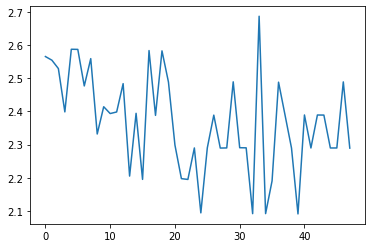

In [21]:
plt.plot(range(0,len(all_losses)),all_losses)

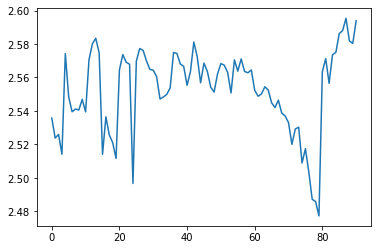

In [17]:
plt.plot(range(0,len(all_losses)),all_losses)